In [1]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical,plot_model
from keras.models import Input,Model,Sequential
from keras.layers import LSTM,Embedding,Dropout,Activation,Reshape,Dense,GRU,Add,Flatten,concatenate

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

In [2]:
data = pd.read_csv('dataset.csv')

In [3]:
data = data.dropna()

In [4]:
data = data.sort_values(by=['Label'], ascending=True)

In [5]:
data = data[0:49972]

In [6]:
data['Label'] = data['Label'].replace({0: 'Fake', 1: 'True'})

In [9]:
data.head(-5)

,Head,Body,Label,Features
16095,interior dãcor spirits away japan food good,price however return ny quickly quite pricey o...,Fake,4.0 4.0 1 4.0 4.263519313304721 1165 4 4
16094,recently went friends,however menu little overwhelming organized goe...,Fake,4.0 4.0 1 4.0 4.263519313304721 1165 8 4
16093,food really amazing service feels like secret ...,careful though hungry want come early come lat...,Fake,4.0 4.0 1 4.0 4.263519313304721 1165 4 4
16092,probaby favorite restaurant recent work trip nyc,pork belly sweet full flavor group also enjoye...,Fake,4.0 4.0 1 4.0 4.263519313304721 1165 5 4
16091,love place authentic japanese food bamboo style,staff super polite like travel japan soba good...,Fake,4.0 4.0 1 4.0 4.263519313304721 1165 5 4
...,...,...,...,...
139720,place super crowded food good good said,soup dumplings worth try nothing different usu...,Fake,3.0 3.0 1 4.0 3.801781737193764 3143 13 3
139721,ever find joe shanghai must try soup dumplings,careful eating though soup hot dumplings punct...,Fake,3.0 2.6666666666666665 3 4.0 3.801781737193764...
139722,nt get hype,like add tip billmy friend went sunday noon li...,Fake,3.0 3.0 1 4.0 3.801781737193764 3143 11 3
16072,reading great reviews decided check place,food greatits even good yes interior fantastic...,Fake,1.0 1.0 1 4.0 4.263519313304721 1165 10 1


In [8]:
df1 = data[0:4000]
df2 = data[4001:49972]
frames = [df2, df1]
data = pd.concat(frames)

In [10]:
data = data.drop("Features", axis=1)  

In [11]:
data['stance_cat'] = data['Label'].map({'Fake':0,'True':1}).astype(int)
data['Label'].value_counts()

True    25069
Fake    24902
Name: Label, dtype: int64

In [12]:
corpus = np.r_[data['Head'].values,data['Body'].values]
print(len(corpus))

vocabulary = []
for sentence in corpus:
    vocabulary.extend(sentence.split(' '))

vocabulary = list(set(vocabulary))
vocab_length = len(vocabulary)
print("Vocabulary Length is {0}".format(vocab_length))

99942
Vocabulary Length is 60973


In [13]:
max_features = 5000
max_nb_words = 24000
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH_HEADLINE = 64
MAX_SEQUENCE_LENGTH_BODY = 64

In [14]:
encoded_docs_headline = [one_hot(sentence,vocab_length) for sentence in data.loc[:,'Head'].tolist()]
padded_docs_headline = pad_sequences(encoded_docs_headline,MAX_SEQUENCE_LENGTH_HEADLINE,padding='post')

encoded_docs_body = [one_hot(sentence,vocab_length) for sentence in data.loc[:,'Body'].tolist()]
padded_docs_body = pad_sequences(encoded_docs_body,MAX_SEQUENCE_LENGTH_BODY,padding='post')


labels = to_categorical(data.loc[:,'stance_cat'])

In [15]:
labels.shape

(49971, 2)

In [16]:

padded_docs_headline_train = padded_docs_headline[:int(len(padded_docs_headline)*0.8),:]
padded_docs_headline_test = padded_docs_headline[int(len(padded_docs_headline)*0.8):,:]

padded_docs_body_train = padded_docs_body[:int(len(padded_docs_body)*0.8),:]
padded_docs_body_test = padded_docs_body[int(len(padded_docs_body)*0.8):,:]

labels_train = labels[:int(len(labels)*0.8),:]
labels_test = labels[int(len(labels)*0.8):,:]

In [17]:
input_headline = Input(shape=[64],name='input_headline')
embedding_headline = Embedding(vocab_length,50,input_length = MAX_SEQUENCE_LENGTH_HEADLINE)(input_headline)
# dense_headline = Dense(16,activation='relu')(embedding_headline)

input_body = Input(shape=[64],name='input_body')
embedding_body = Embedding(vocab_length,50,input_length = MAX_SEQUENCE_LENGTH_BODY)(input_body)
# dense_body = Dense(16,activation='relu')(embedding_body)

addition_layer = concatenate([embedding_headline,embedding_body])
lstm = LSTM(units=64)(addition_layer)
# drop = Dropout(0.25)(lstm)

# flatten = Flatten()(addition_layer)
output = Dense(2,activation='sigmoid')(lstm)

model_combined = Model(inputs=[input_headline,input_body],outputs=output)

model_combined.compile(optimizer = 'adam',loss ='categorical_crossentropy',metrics = ['accuracy'])

In [18]:

model_combined.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_headline (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_body (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 50)       3048650     input_headline[0][0]             
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 64, 50)       3048650     input_body[0][0]                 
______________________________________________________________________________________________

In [19]:
model_combined.fit([padded_docs_headline_train,padded_docs_body_train],labels_train,epochs=15,verbose=1,validation_data=([padded_docs_headline_test,padded_docs_body_test],labels_test))

Epoch 1/15
1250/1250 [==============================] - 64s 50ms/step - loss: 0.6559 - accuracy: 0.6143 - val_loss: 0.7378 - val_accuracy: 0.5636
Epoch 2/15
1250/1250 [==============================] - 62s 50ms/step - loss: 0.4715 - accuracy: 0.7864 - val_loss: 0.8326 - val_accuracy: 0.5602
Epoch 3/15
1250/1250 [==============================] - 62s 50ms/step - loss: 0.3467 - accuracy: 0.8554 - val_loss: 0.9727 - val_accuracy: 0.5412
Epoch 4/15
1250/1250 [==============================] - 62s 49ms/step - loss: 0.2660 - accuracy: 0.8922 - val_loss: 1.2186 - val_accuracy: 0.5303
Epoch 5/15
1250/1250 [==============================] - 62s 49ms/step - loss: 0.2129 - accuracy: 0.9135 - val_loss: 1.5546 - val_accuracy: 0.5269
Epoch 6/15
1250/1250 [==============================] - 62s 49ms/step - loss: 0.1704 - accuracy: 0.9329 - val_loss: 1.9495 - val_accuracy: 0.5355
Epoch 7/15
1250/1250 [==============================] - 62s 49ms/step - loss: 0.1331 - accuracy: 0.9499 - val_loss: 1.9327 -

Correct predictions: 5243.0
Total number of test examples: 9995
Accuracy of model1:  0.5245622811405702
f1_score(macro): 0.5239588022728834


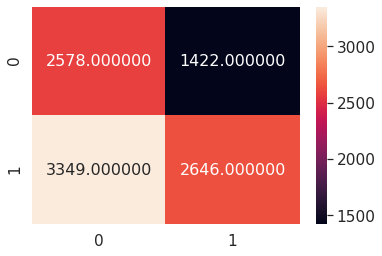

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
test_preds = model_combined.predict([padded_docs_headline_test,padded_docs_body_test])
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == labels_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(labels_test))
print("Accuracy of model1: ", correct_predictions/float(len(labels_test)))
from sklearn.metrics import  f1_score
print("f1_score(macro): {}".format(f1_score(labels_test, test_preds, average="macro")))
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = model_combined.predict([padded_docs_headline_test,padded_docs_body_test])
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = labels_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm,annot=True,annot_kws={"size": 16},fmt='1f')# font size